load vit model and use lime


/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

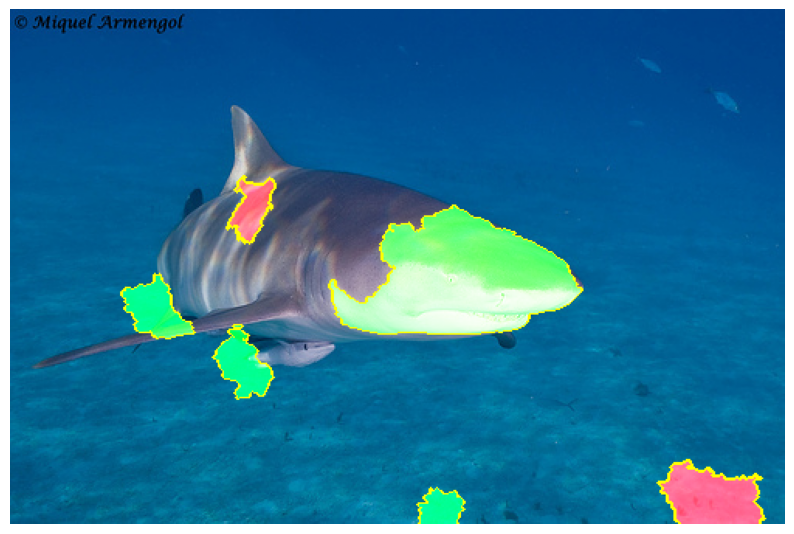

In [2]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# 加载预训练的ViT模型和特征提取器
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# 加载和预处理本地图像
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return img

# 使用本地图像文件
image_path = "n01491361/ILSVRC2012_val_00007743_n01491361.JPEG"
img = load_image(image_path)
inputs = feature_extractor(images=img, return_tensors="pt")

# 获取模型预测
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()

# 使用LIME进行解释
def batch_predict(images):
    model.eval()
    inputs = feature_extractor(images=[Image.fromarray(img) for img in images], return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
    return probs.detach().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img), batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# 可视化解释结果
temp, mask = explanation.get_image_and_mask(pred_class, positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp / 255.0, mask)

plt.figure(figsize=(10, 10))
plt.imshow(img_boundry)
plt.axis('off')
plt.show()


use finetuned Vit Model


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([400]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([400, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

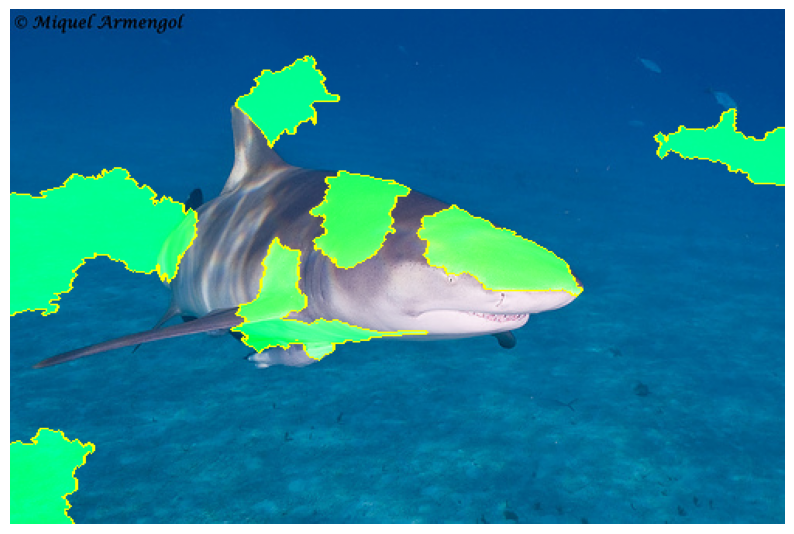

In [4]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Specify the path to the saved finetuned model
model_save_path = "finetuned_vit_model.pth"

# Load the finetuned model
# Load the model ignoring the mismatched sizes in the classifier
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=400,  # the number of labels you need in your application
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load(model_save_path), strict=False)  # Using strict=False is optional but may be useful
model.eval()


# Load the corresponding feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Load and preprocess an image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return img

image_path = "n01491361/ILSVRC2012_val_00007743_n01491361.JPEG"
img = load_image(image_path)
inputs = feature_extractor(images=img, return_tensors="pt")

# Predict using the loaded model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()

# Use LIME for explanation
def batch_predict(images):
    model.eval()
    inputs = feature_extractor(images=[Image.fromarray(img) for img in images], return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
    return probs.detach().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img), batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(pred_class, positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp / 255.0, mask)

plt.figure(figsize=(10, 10))
plt.imshow(img_boundry)
plt.axis('off')
plt.show()


video data vit and lime


/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

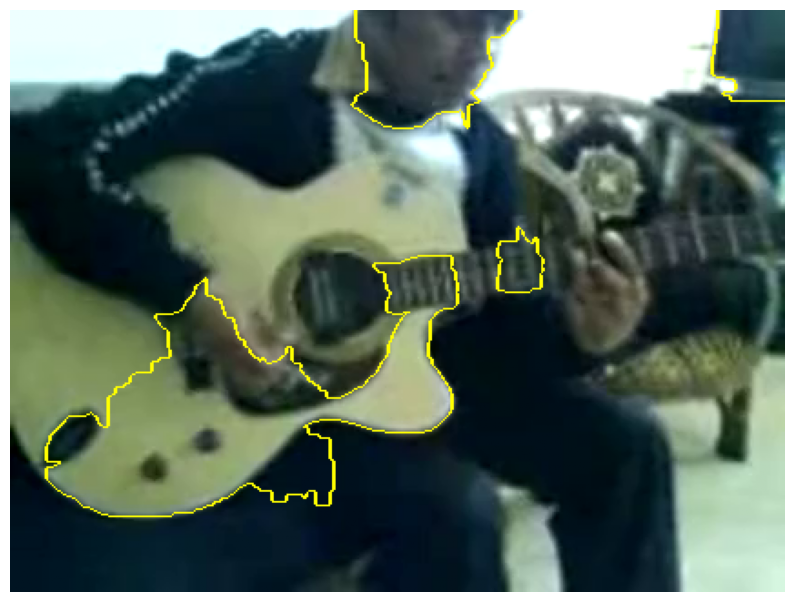

In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import av  # 导入用于读取视频的库

# 加载微调后的模型
model_path = "finetuned_vit_model.pth"  # 模型文件路径
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=400)
model.load_state_dict(torch.load(model_path))
model.eval()

# 加载特征提取器
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# 定义从视频中加载帧的函数
def load_frame(video_path):
    container = av.open(video_path)
    frame = next(container.decode(video=0)).to_image()  # 获取第一个视频帧
    container.close()
    return frame

# 使用视频帧
video_path = 'archive/videos_val/__vzEs2wzdQ.mp4'  # 视频文件路径
frame = load_frame(video_path)
inputs = feature_extractor(images=frame, return_tensors="pt")

# 获取模型预测
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()

# 使用LIME进行解释
def batch_predict(images):
    inputs = feature_extractor(images=[Image.fromarray(img.astype('uint8')) for img in images], return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(frame), batch_predict, top_labels=5, hide_color=0, num_samples=1000)

# 可视化解释结果
temp, mask = explanation.get_image_and_mask(pred_class, positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(np.array(frame) / 255.0, mask)

plt.figure(figsize=(10, 10))
plt.imshow(img_boundry)
plt.axis('off')
plt.show()
